# Regresión y clasificación

## Regresión

Entregable: Construir una red neuronal de regresión para predecir el precio de las viviendas. Use los datos Boston Housing.  Los datos los puede encontrar en el enlace de Kaggle.

## 1. Importar librerías

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## 2. Carga de datos

In [2]:
#cargamos los datos de entrada 
name= ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data_h = pd.read_csv("housing.csv",delim_whitespace=True,names=name)
data_h.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## 3. Preprocesamiento

Detecta datos faltantes y elimina filas

In [3]:
data_h.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [4]:
data_h = data_h.dropna()

In [5]:
# Datos de entrenamiento y test
train_data_h = data_h.sample(frac=0.8,random_state=0)
test_data_h = data_h.drop(train_data_h.index)

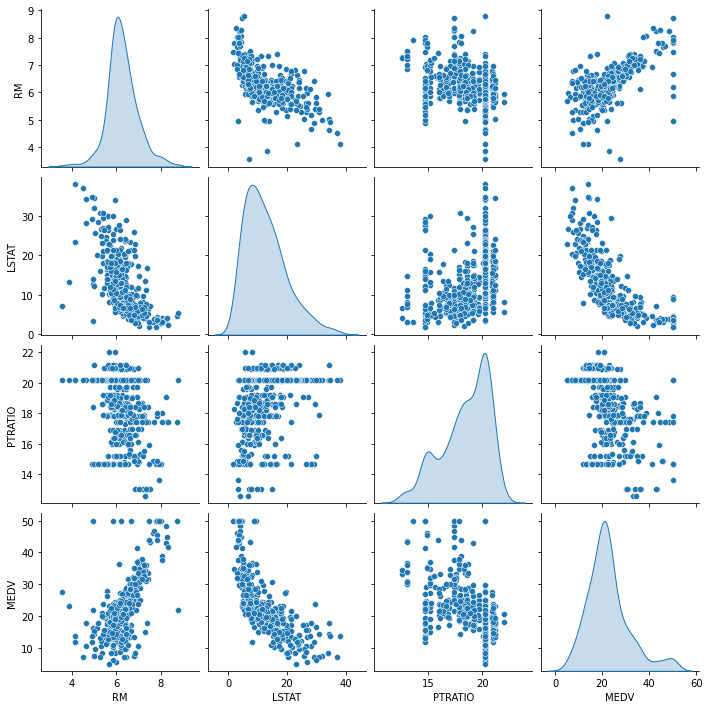

In [6]:
# Descriptivo de algunas variables
sns.pairplot(train_data_h[["RM", "LSTAT", "PTRATIO", "MEDV"]], diag_kind="kde")

In [7]:
# estadisticas generales
train_stats = train_data_h.describe()
train_stats.pop("MEDV")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
CRIM,405.0,3.670339,8.977954,0.00632,0.08265,0.26838,3.47428,88.9762
ZN,405.0,11.067901,22.688396,0.00000,0.00000,0.00000,12.50000,95.0000
INDUS,405.0,11.097951,6.699157,0.74000,5.32000,9.69000,18.10000,27.7400
CHAS,405.0,0.069136,0.253999,0.00000,0.00000,0.00000,0.00000,1.0000
NOX,405.0,0.553098,0.115564,0.38500,0.44900,0.53800,0.62400,0.8710
RM,405.0,6.269768,0.690552,3.56100,5.87800,6.19300,6.61900,8.7800
AGE,405.0,68.241975,27.908527,2.90000,45.00000,76.50000,94.10000,100.0000
DIS,405.0,3.834098,2.162173,1.12960,2.07880,3.27210,5.21460,12.1265
RAD,405.0,9.474074,8.618564,1.00000,4.00000,5.00000,24.00000,24.0000
TAX,405.0,405.839506,164.057951,187.00000,284.00000,334.00000,666.00000,711.0000


In [8]:
# Separe caracteristicas y etiquetas
train_labels = train_data_h.pop('MEDV')
test_labels = test_data_h.pop('MEDV')

In [9]:
# Normalización de datos
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_data_h)
normed_test_data = norm(test_data_h)

## 4. Creación del modelo Functional

In [10]:
# modelo secuencial con dos capas ocultas densamente conectadas 
# y una capa de salida que devuelve un único valor continuo

class Regression(Model):
    def __init__(self):
        super(Regression,self).__init__()
        self.dense1 = Dense(64, activation='relu')
        self.dropout1 = Dropout(0.4)
        self.dense2 = Dense(32, activation='relu')
        self.dropout2 = Dropout(0.4)
        self.dense_out = Dense(1)

    def call(self,x):
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        return(self.dense_out(x))

model = Regression()

## 5. Compila

In [11]:
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

## 6. Entrenamiento

In [12]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

epochs = 500

history = model.fit(
  normed_train_data, train_labels,
  epochs=epochs, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Model: "regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  896       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  2080      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  33        
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________


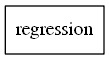

In [13]:
model.summary()
plot_model(model, to_file='housin.png', 
           show_shapes=True)

In [14]:
# progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto history
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
495,21.945560,3.502971,21.945560,13.439878,2.613962,13.439878,495
496,28.262197,3.922408,28.262197,12.697562,2.481717,12.697562,496
497,26.154655,3.683786,26.154655,12.679163,2.360013,12.679163,497
498,30.770960,4.153553,30.770960,12.084178,2.242093,12.084178,498
499,25.489523,3.780584,25.489523,12.046099,2.276277,12.046099,499


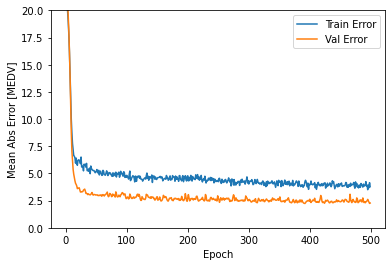

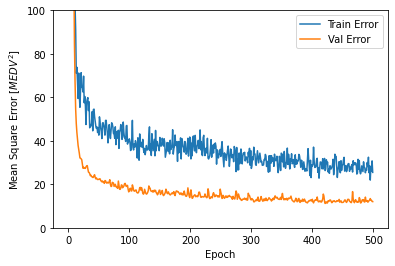

In [15]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MEDV]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MEDV^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,100])
  plt.legend()
  plt.show()


plot_history(history)


...............................

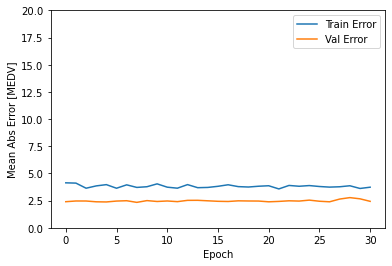

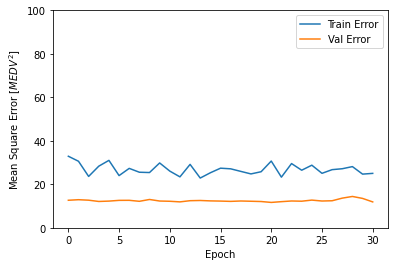

In [16]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=epochs,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [17]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MEDV".format(mae))

4/4 - 0s - loss: 6.8290 - mae: 1.9428 - mse: 6.8290
Testing set Mean Abs Error:  1.94 MEDV


## 7. Predicciones

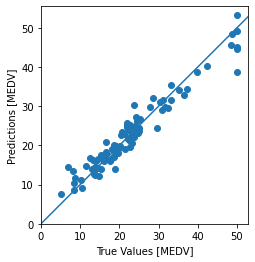

In [18]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MEDV]')
plt.ylabel('Predictions [MEDV]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

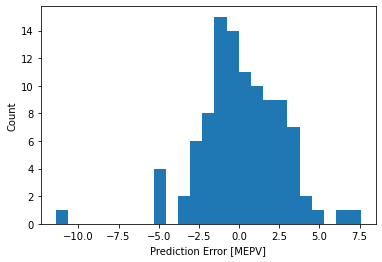

In [19]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MEPV]")
_ = plt.ylabel("Count")